# **Housing Market Analysis**

In this demonstration, I will be performing exploratory analysis on the commonly-used California Housing dataset.

The purpose of this is to later apply a Neural Network algorithm to predict housing prices.

I am going to be using a version of this dataset from Github rather than sklearn as it includes the "ocean_proximity" variable for a further geographical element to the market segmentation.

Further details about this dataset can be found here: https://github.com/ageron/handson-ml2/tree/master/datasets/housing.


In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os
import pandas as pd
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# **Data**

Load and inspect the data

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [ ]:
housing = load_housing_data()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
housing.info()

# ocean_proximity is our only non-numerical variable, which we will have to work with differently

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
# lets create a copy of the housing dataset where ocean proximity os replaced with an index
# This will help in things such as correlation tables.

housing_num = housing.copy()

ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}

housing_num['ocean_proximity_index'] = housing_num['ocean_proximity'].map(ocean_proximity_mapping)

housing_num = housing_num.drop(columns=['ocean_proximity'])


In [ ]:
# download California map
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(filename))

('california.png', <http.client.HTTPMessage at 0x7d3434071c50>)

Saving figure Figure 1: california_housing_prices_plot


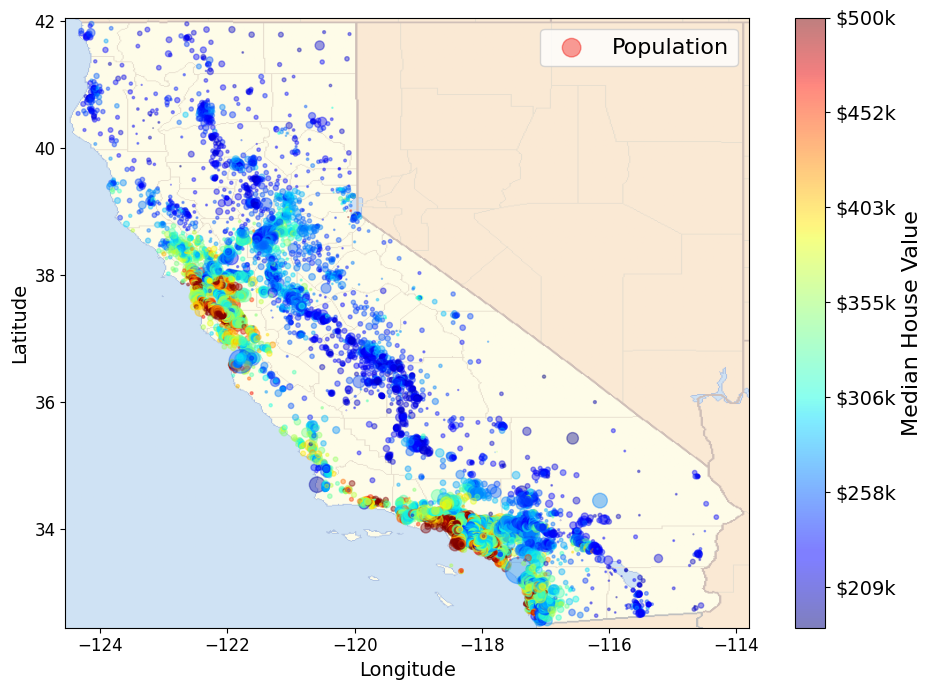

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(filename)
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("Figure 1: california_housing_prices_plot")
plt.show()

In [ ]:
category_counts = housing["ocean_proximity"].value_counts()
category_percentages = housing["ocean_proximity"].value_counts(normalize=True) * 100
median_prices_by_ocean_proximity = housing.groupby("ocean_proximity")["median_house_value"].median()

# Combine both into a single DataFrame for better visualization
category_summary = pd.DataFrame({
    "Count": category_counts,
    "Percentage": category_percentages,
    "Median House Price" : median_prices_by_ocean_proximity})

# Display the summary
print(category_summary)

# here we can see the distrution of housing categories by ocean proximity. The largest category is <H Ocean with about 44% of the total.
# Figure 1 above confirms wthis, with their being the highest visible density by the ocean.

                 Count  Percentage  Median House Price
ocean_proximity                                       
<1H OCEAN         9136   44.263566            214850.0
INLAND            6551   31.739341            108500.0
ISLAND               5    0.024225            414700.0
NEAR BAY          2290   11.094961            233800.0
NEAR OCEAN        2658   12.877907            229450.0


In [ ]:
# Statistical description of the data
housing.describe()
# N = 20640 small, 207 blocks are missing observations for total_bedrooms. We can either impute values for these missing observations, or limit ourselves to using the 20433 complete observations.
# Median income is scaled to some scale between 0.5 and 15, and probably top-coded as most income data is.
# Housing price was capped at 500K. This will cause a large clustering of observations at this amount, as every house with a value above 500k will just be recorded at 500k.

# Median house age was also top coded at 52

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure Figure 2: attribute_histogram_plots


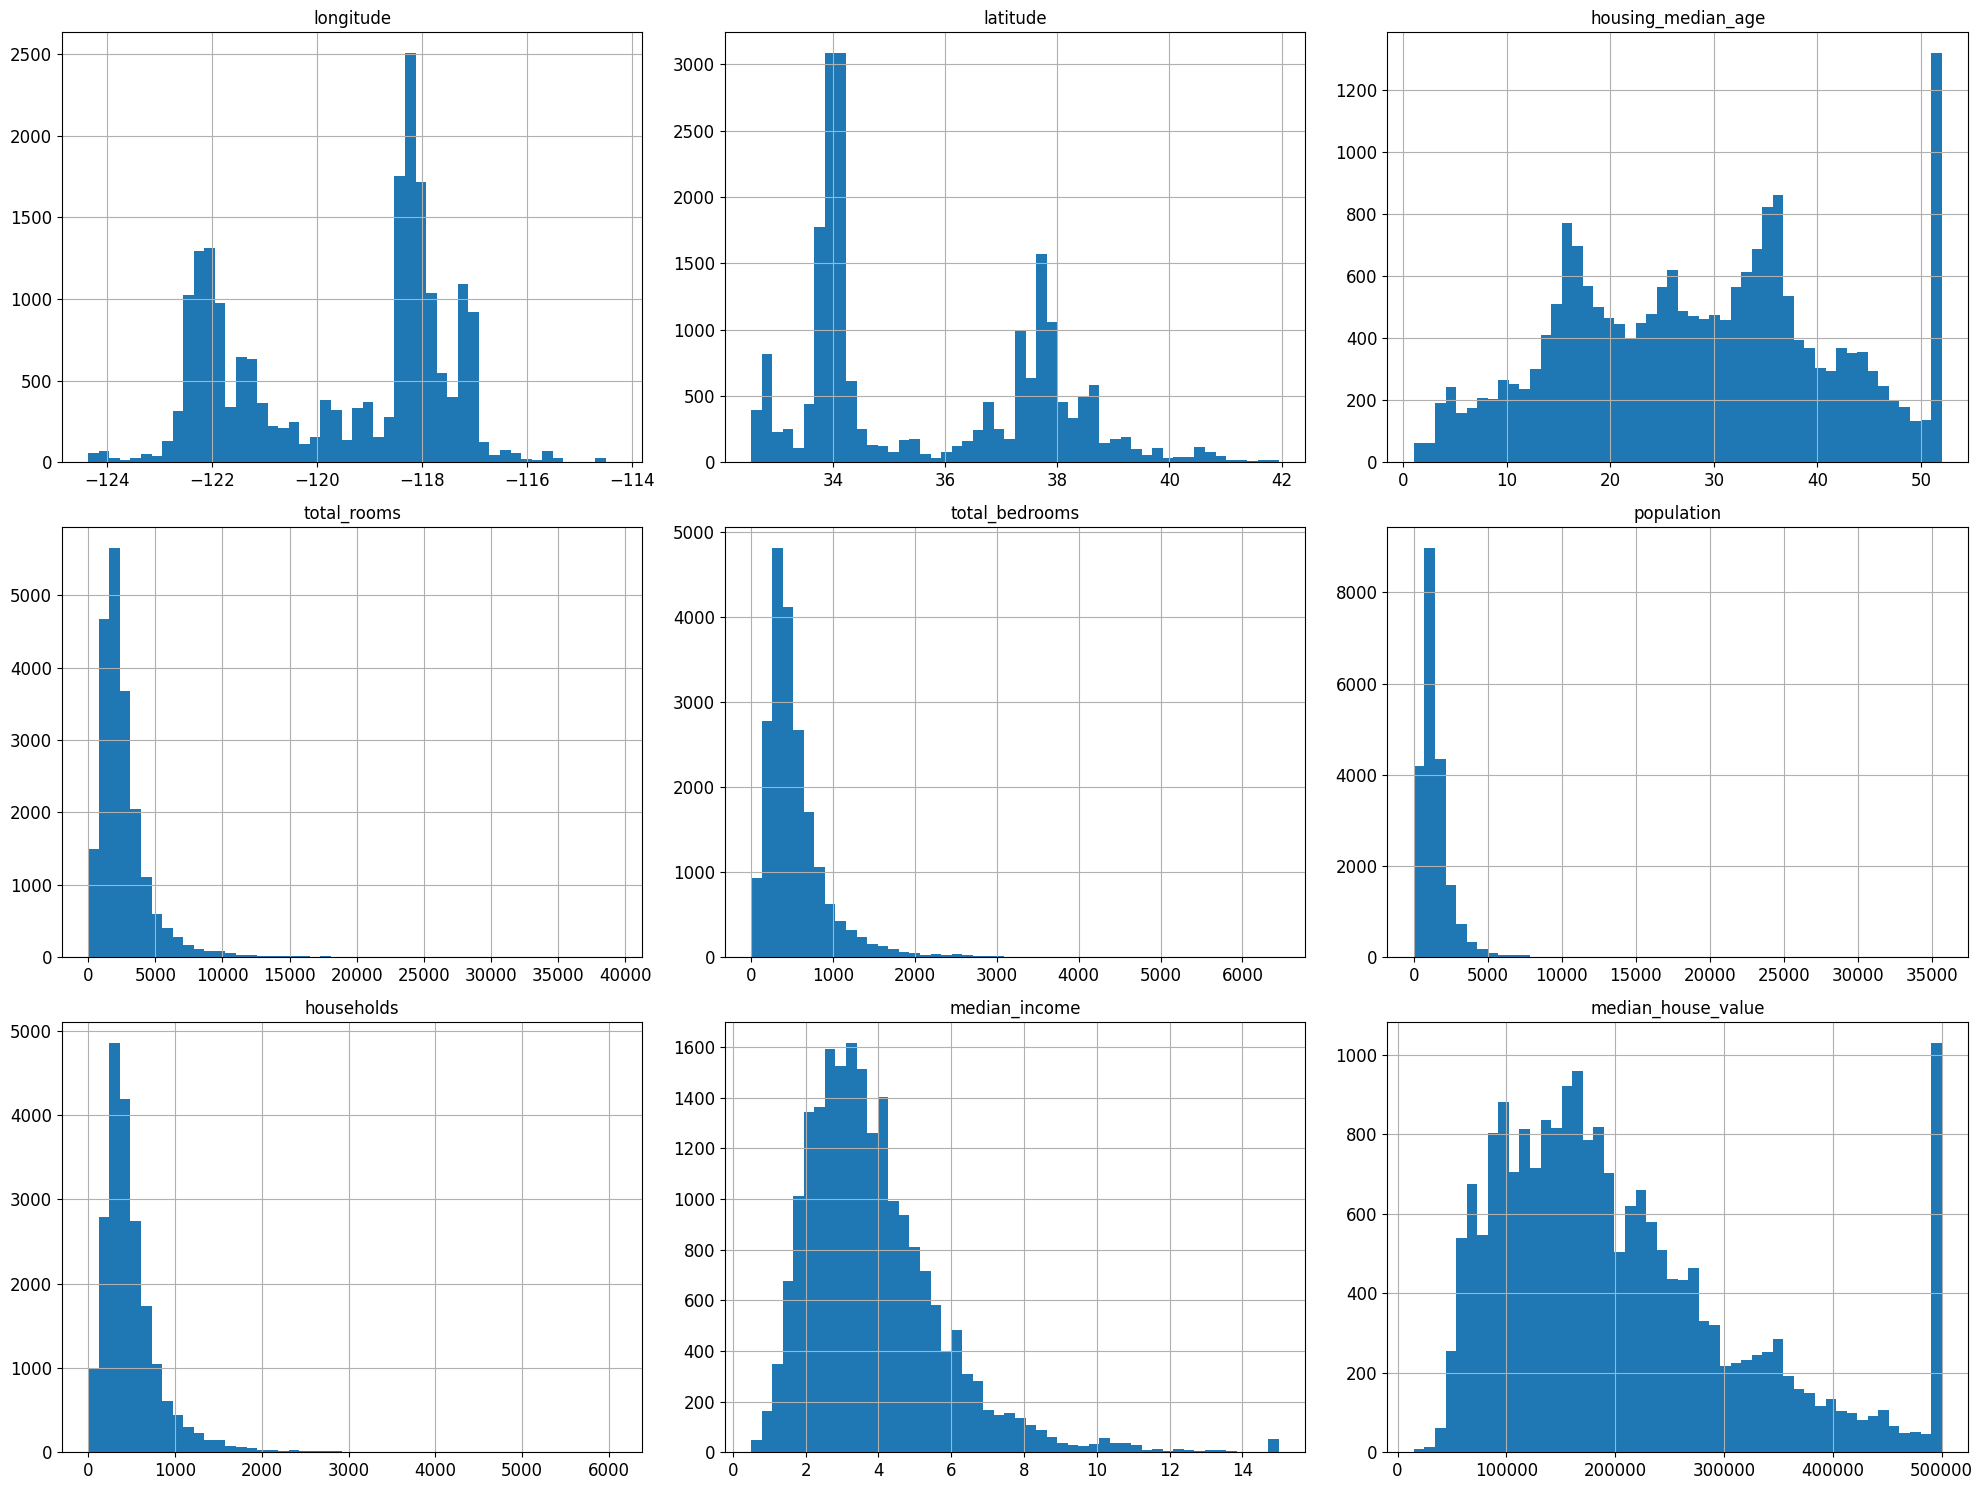

In [ ]:
# Visualize the data with histograms

housing.hist(bins=50, figsize=(20,15))
save_fig("Figure 2: attribute_histogram_plots")
plt.show()

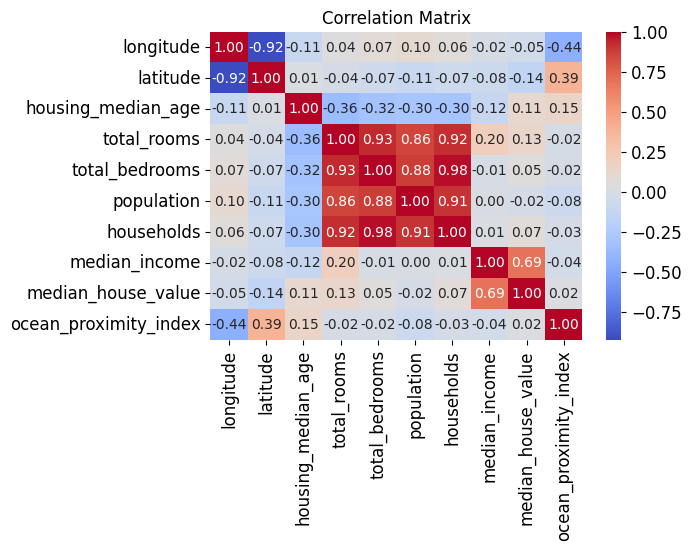

In [ ]:
import seaborn as sns

# Computing Correlation Matrix
corr_matrix = housing_num.corr()
corr_matrix

# Generating a Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

# this shows the correlations with median house value in descending order.
# Median income appears to be our most important variable by a wide margin.

,median_house_value
median_house_value,1.000000
median_income,0.688075
total_rooms,0.134153
housing_median_age,0.105623
households,0.065843
total_bedrooms,0.049686
ocean_proximity_index,0.021732
population,-0.024650
longitude,-0.045967
latitude,-0.144160


Saving figure income_vs_house_value_scatterplot_with_line


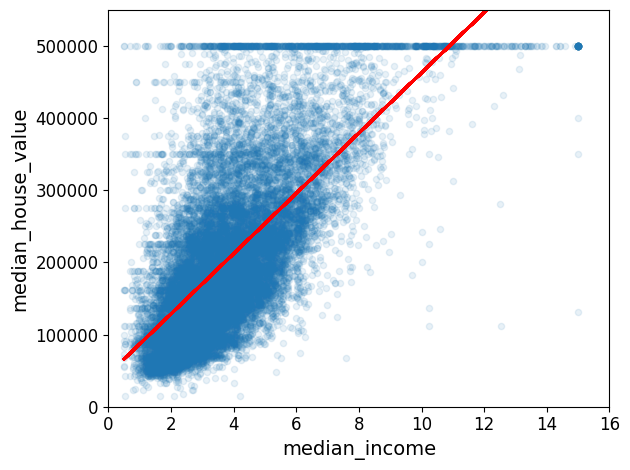

In [ ]:
# Scatter plot
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

# Calculate the linear regression line
x = housing["median_income"]
y = housing["median_house_value"]
slope, intercept = np.polyfit(x, y, 1)  # Linear regression: y = mx + b

# Plot the regression line
plt.plot(x, slope * x + intercept, color="red", linewidth=2)

# Customize axes
plt.axis([0, 16, 0, 550000])

# Save and show the plot
save_fig("income_vs_house_value_scatterplot_with_line")
plt.show()